In [1]:
# from importlib import reload  

from tic_tac_toe import TicTacToe
from agents import DQNAgent, RandomAgent

import random
import numpy as np
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set(rc={
    'figure.figsize': (15, 8),
    'legend.fontsize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16
})


SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## DQN

In [6]:
def train_dqn(env, x_agent, o_agent, n_episodes):
    # train against itself
    agents = {
            1: x_agent, -1: o_agent
        }
    for _ in range(n_episodes):
        env.reset()        
        state, empty_cells, turn = env.getState()
        agents[1].curr_action, agents[-1].curr_action = None, None
        done = False
        
        while not done:
            action = agents[turn].select_action(state)
            agents[turn].update_memory(state, action, 0)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
            
        agents[1].step(state, action, reward)
        agents[-1].step(state, action, reward)

def validate_dqn(env, dqn_agent, n_episodes):
    # validate against random agent
    if dqn_agent.side == 'o':
        agents = { 
            1: RandomAgent(), -1: dqn_agent
        }
    else:
        agents = {
            1: dqn_agent, -1: RandomAgent()
        }
    all_rewards = []
    
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        done = False
        while not done:
            action = agents[turn].select_best_action(state)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        all_rewards.append(reward)
    
    return all_rewards

### 3x3 board

x-agent. Using device: cuda
o-agent. Using device: cuda


100%|██████████| 100/100 [11:03<00:00,  6.64s/it]


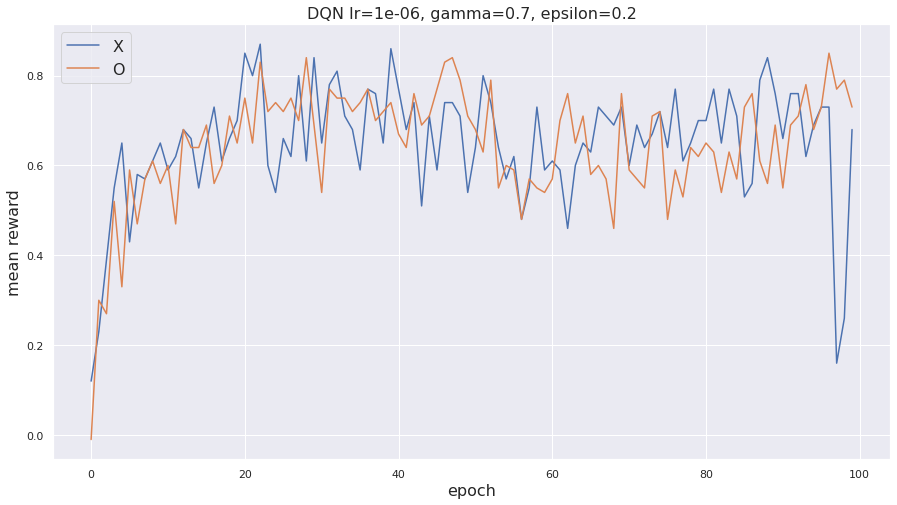

In [7]:
BATCH_SIZE = 256
HID_SIZE = 128
BUF_SIZE = 10_000
LR = 1e-6
GAMMA = .7
EPS = .2
UPDATE_EVERY = 4
UPDATE_TARGET_EVERY = 2_000

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()
    
x_agent = DQNAgent(QNetwork, HID_SIZE, 3, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'x')
o_agent = DQNAgent(QNetwork, HID_SIZE, 3, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'o')

# evaluate each agent every 1_000 episodes of training
N_EPOCHS = 100
x_means, o_means = [], []

for _ in tqdm(range(N_EPOCHS)):
    train_dqn(env, x_agent, o_agent, 1_000)
    x_means.append(np.mean(validate_dqn(env, x_agent, 100)))
    o_means.append(np.mean(validate_dqn(env, o_agent, 100)))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'DQN lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

Оба агента обучились примерно одинаково, но не дошли до идеальной стратегии

### 4x4 board

x-agent. Using device: cuda
o-agent. Using device: cuda


100%|██████████| 150/150 [24:35<00:00,  9.84s/it]


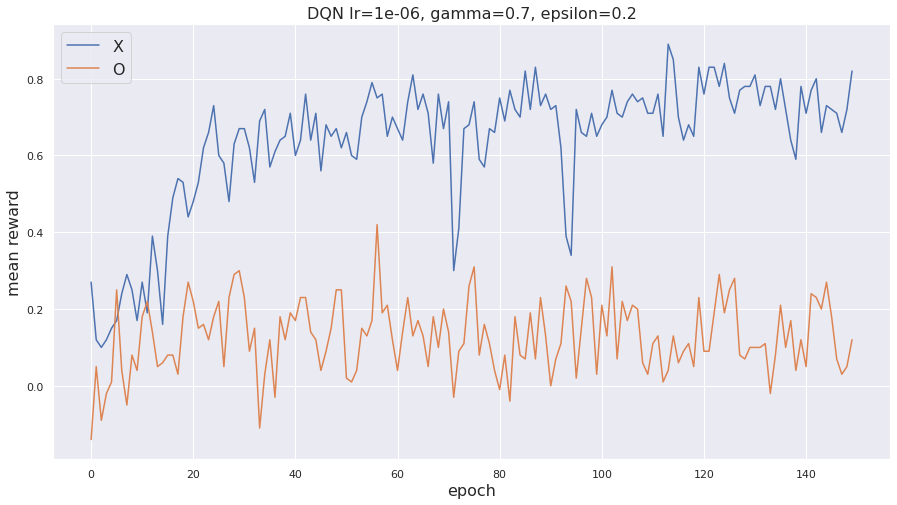

In [8]:
BATCH_SIZE = 256
HID_SIZE = 256
BUF_SIZE = 10_000
LR = 1e-6
GAMMA = .7
EPS = .2
UPDATE_EVERY = 4
UPDATE_TARGET_EVERY = 2_000

env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
state, _, _ = env.getState()
    
x_agent = DQNAgent(QNetwork, HID_SIZE, 4, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'x')
o_agent = DQNAgent(QNetwork, HID_SIZE, 4, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'o')

# evaluate each agent every 1_000 episodes of training
N_EPOCHS = 150
x_means, o_means = [], []

for _ in tqdm(range(N_EPOCHS)):
    train_dqn(env, x_agent, o_agent, 1_000)
    x_means.append(np.mean(validate_dqn(env, x_agent, 100)))
    o_means.append(np.mean(validate_dqn(env, o_agent, 100)))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'DQN lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

Крестикам получилось выйти на некоторый оптимум, нолики же остались практически там же, где и начинали

## Dueling DQN

### 3x3 board

x-agent. Using device: cuda
o-agent. Using device: cuda


100%|██████████| 100/100 [12:35<00:00,  7.55s/it]


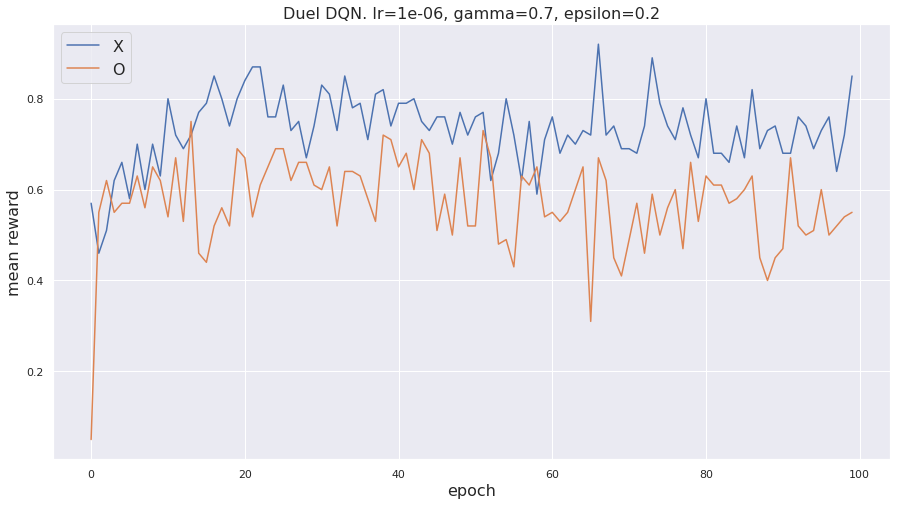

In [9]:
BATCH_SIZE = 256
HID_SIZE = 128
BUF_SIZE = 10_000
LR = 1e-6
GAMMA = .7
EPS = .2
UPDATE_EVERY = 4
UPDATE_TARGET_EVERY = 2_000

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()
    
x_agent = DQNAgent(DuelingDQNet, HID_SIZE, 3, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'x')
o_agent = DQNAgent(DuelingDQNet, HID_SIZE, 3, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'o')

# evaluate each agent every 1_000 episodes of training
n_epochs = 100
x_means = []
o_means = []

for _ in tqdm(range(n_epochs)):
    train_dqn(env, x_agent, o_agent, 1_000)
    x_means.append(np.mean(validate_dqn(env, x_agent, 100)))
    o_means.append(np.mean(validate_dqn(env, o_agent, 100)))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'Duel DQN. lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

Получилось примерно так же, как и на классическом DQN 3x3 

### 4x4 board

x-agent. Using device: cuda
o-agent. Using device: cuda


100%|██████████| 150/150 [19:04<00:00,  7.63s/it]


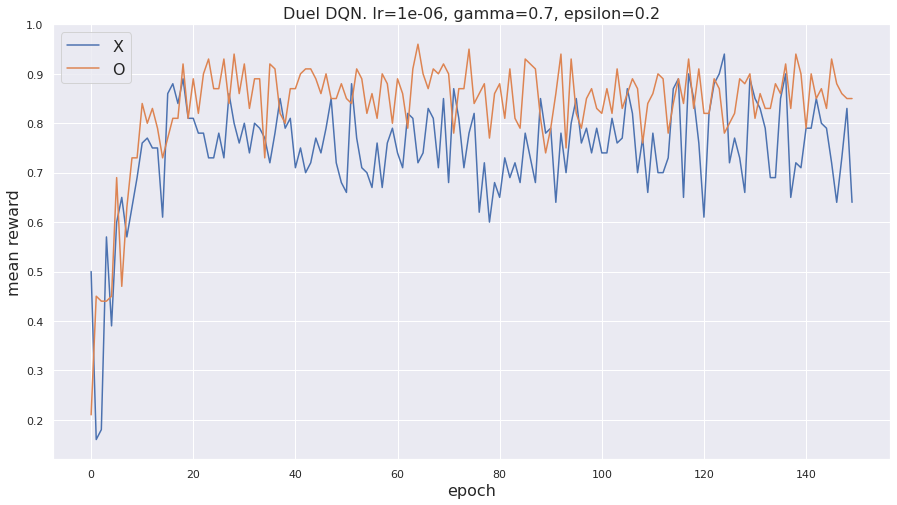

In [10]:
BATCH_SIZE = 256
HID_SIZE = 512
BUF_SIZE = 10_000
LR = 1e-6
GAMMA = .7
EPS = .2
UPDATE_EVERY = 4
UPDATE_TARGET_EVERY = 2_000

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()
    
x_agent = DQNAgent(DuelingDQNet, HID_SIZE, 3, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'x')
o_agent = DQNAgent(DuelingDQNet, HID_SIZE, 3, len(state), BUF_SIZE, BATCH_SIZE,
                   LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'o')

# evaluate each agent every 1_000 episodes of training
n_epochs = 150
x_means = []
o_means = []

for _ in tqdm(range(n_epochs)):
    train_dqn(env, x_agent, o_agent, 1_000)
    x_means.append(np.mean(validate_dqn(env, x_agent, 100)))
    o_means.append(np.mean(validate_dqn(env, o_agent, 100)))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'Duel DQN. lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

Нашли почти идеальные стратегии как для крестиков, так и для ноликов, причем за время, сопоставимое с обучением на доске 3х3. Отчасти такой эффект мог получиться из-за выбора более крупного **HID_SIZE** (гиперпараметр для размерности выхода на сверточном слое). Но скорее всего тут все же сыграла обновленная архитектура сети.